In [15]:
from Model_GPR import Model,GPR,gamma,normal,RBF_2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, cm
import pandas as pd

## Generate Data

In [24]:
import numpy as np
np.random.seed(4433) 
noise = 0.25
x, y = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
xx, yy = np.meshgrid(x, y)
X_2D = np.c_[xx.ravel(), yy.ravel()]
X_obs = np.random.uniform(-4, 4, (100, 2))
Y_obs = np.sin(np.linalg.norm(X_obs, axis=1))-np.tanh(0.5*np.linalg.norm(X_obs,axis=1)) + \
             noise * np.random.randn(len(X_obs))

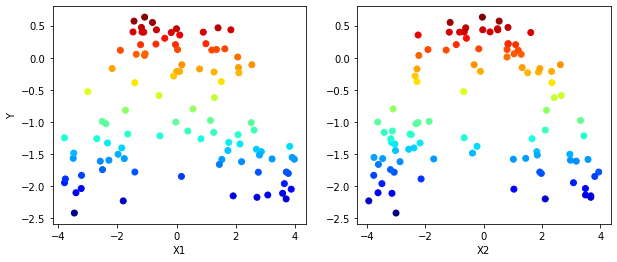

In [25]:
fig_1 ,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
ax1.scatter(X_obs[:,0],Y_obs, c=Y_obs, cmap=cm.jet)
ax1.set_xlabel('X1')
ax1.set_ylabel('Y')
ax2.scatter(X_obs[:,1],Y_obs,c=Y_obs,cmap=cm.jet)
ax2.set_xlabel('X2');

## Define Model

We use three gamma priors for the unkown hyperparameters $\ell$, $\sigma$ and noise level $\sigma_{\text{noise}}$

\begin{align}
    \ell \sim \Gamma(2.0,3.0)\\
    \sigma  \sim \Gamma(2.0,3.0)\\
    \sigma\_{\text{noise}}\sim \Gamma(2.0,3.0)
\end{align}

and define the model chronologically. This means we start by defining the prior assumptions for the hyperparameters and noise level. After doing this we choose a covariance function - in this example we use the RBF Kernel to model the covariance between the input points. We can print a summary of the defined model (optional).
The last step is to use the MAP function of the model to find the optimized parameters. The initial guess was arbitrairly set to 1,1,0.3.

In [26]:
test_model = GPR("Test_1")
with test_model as model_2:
    model_2.add_prior("ℓ",gamma(2,3))
    model_2.add_prior("σ",gamma(2,3))
    model_2.add_prior("noise", gamma(2,3))
    model_2.add_cov(RBF_2)
    model_2.summarize()
    res = model_2.MAP(X_obs,Y_obs,theta=[1, 1,0.3])
print(res)

model:Test_1
 self.prior :{'ℓ': <Model_GPR.gamma object at 0x000001D9274DACC0>, 'σ': <Model_GPR.gamma object at 0x000001D9274DA198>, 'noise': <Model_GPR.gamma object at 0x000001D928639C88>}
      fun: 41.98320755172098
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00035953,  0.00021458,  0.00072475])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 72
      nit: 14
   status: 0
  success: True
        x: array([1.98276513, 1.18261936, 0.22428984])


## The posterior distribution with optimized parameters

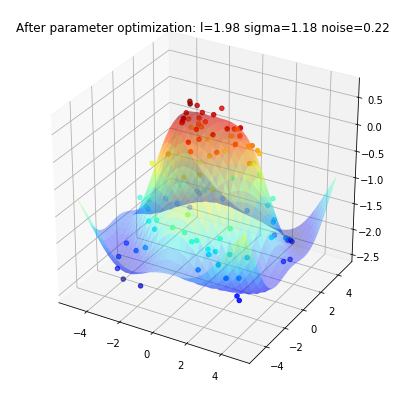

In [52]:
model_2.posterior_dist(X_2D,X_obs,Y_obs)
fig_2 = plt.figure(figsize=(7,7))
model_2.plot_post_dist(xx,yy,X_obs,Y_obs,"After parameter optimization: l={} sigma={} noise={}".format(np.round(res.x[0],2),np.round(res.x[1],2),np.round(res.x[2],2)))

## The variation of the parameters while optimization

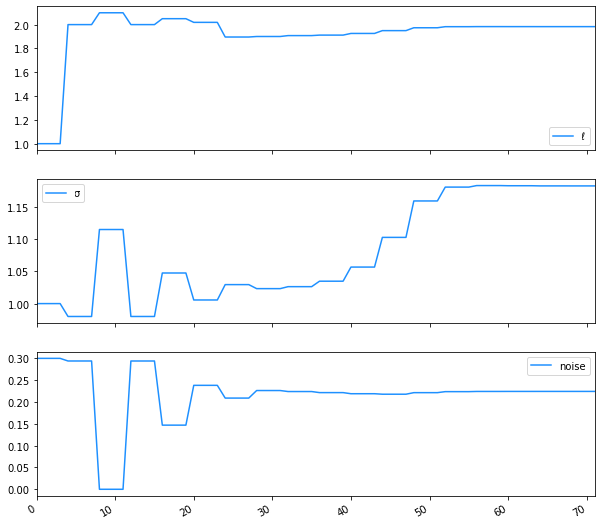

In [28]:
model_2.theta_df.plot(subplots=True,layout=(3,1),figsize=(10,10), color='dodgerblue');

## Average trainings loss for 10 function evaluations

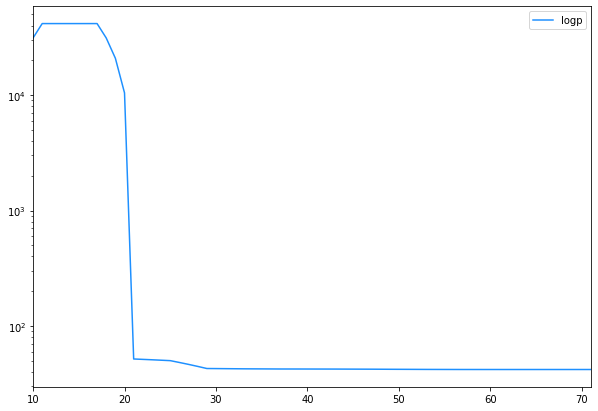

In [42]:
fig_3,ax = plt.subplots(figsize=(10,7))
pd.DataFrame(model_2.training_loss, columns=['logp']).rolling(10).mean()[10:].plot(color='dodgerblue', ax=ax)
ax.set_yscale('log')

## Second approach with pymc3

In [6]:
import pymc3 as pm
import theano
import theano.tensor as tt

We define the same model as before. Again we start by defining the prior distributions for the kernel hyperparameter. After doing this we select a covariance function. In contrast to above, we first need to define a Gaussian process with the selected covariance function. Note that the covariance function itself stores the prior assumptions as random variables. Then we define a prior distribution for the noise level and finally construct the loglikelihood of the modell. Finally we can use the find_MAP method to optimize the parameters.

In [44]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2.0, beta=3.0)
    σ = pm.Gamma("σ", alpha=2.0,beta=3.0)
    
    cov = σ ** 2 * pm.gp.cov.ExpQuad(2, ℓ)
    gp = pm.gp.Marginal(cov_func=cov)

    σ_noise = pm.Gamma("σ_noise", alpha=2.0,beta=3.0)
    y_ = gp.marginal_likelihood("y", X=X_obs, y=Y_obs, noise=σ_noise)

    mp = pm.find_MAP(method='BFGS')

We can now check if the pymc3 optimized hyperparameter lead to any significant differences to the optimized solution with the help of our model.

In [45]:
np.array([mp['ℓ'], mp['σ'], mp['σ_noise']])-model_2.theta

array([ 4.45540351e-06, -2.93789337e-06,  2.19265023e-05])